The sizes of the training set and testing set are 90 and 60 respectively


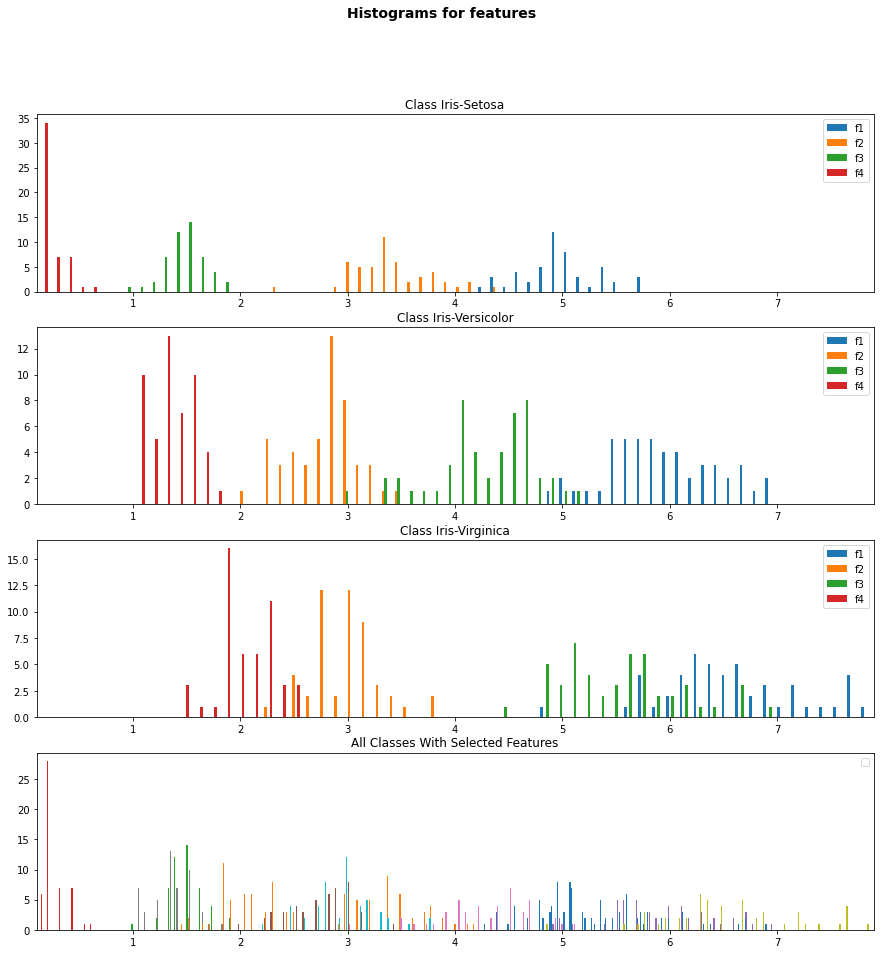

In [340]:
# Imports
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# Settings - more below
data_file = "iris.csv"
start = 0 # Training set range
many = 30
feature_omitted = -1 # Four features (0-3) - (-1) then no feature is omitted - ex. [0,3] - Affects Gradient Descent and splitting
selected_feature = [1,1,1,1] # Features (0-3) - [0,1,0,..] multiple - if -1 then all features are selected - Affects Histograms

# Split data sets: def split_sets_and_dummy(file, start, many, omit):
[df_train, hot_classes_train, features_train, df_test, hot_classes_test, features_test, df, df_original] =\
split_sets_and_dummy(data_file, start, many, feature_omitted)
print("The sizes of the training set and testing set are %d and %d respectively" % (features_train.shape[0], features_test.shape[0]) )

# Settings-based histograms
histograms(df_original, selected_feature, feature_omitted)

In [341]:
# Settings - more up
training_precision = 3.5 # Difference between two consecutive runs in percent
learning_rate = 0.03
max_iterations = 5000

# Perform Gradient Descent: def grad_descent(feat_train, omit, classes, lr, tp, mi = 5000):
start = timer()
[weights, count] = grad_descent(features_train, feature_omitted, hot_classes_train, learning_rate, training_precision, mi = max_iterations)
end = timer()
print("Training finished after %d iterations in %f" % (count, end - start))
print("The found weights are:\n", weights)

# Make a confusion matrix using test data: conf_and_terr(feat_test, classes, weights)
[conf_mat, error_percent] = conf_and_terr(features_test, hot_classes_test, weights)
print("The error rate is %.2f%% using the test set with a confusion matrix of:\n" % error_percent)
display(conf_mat)

# Make a confusion matrix using training data: conf_and_terr(feat_test, classes, weights)
[conf_mat, error_percent] = conf_and_terr(features_train, hot_classes_train, weights)
print("The error rate is %.2f%% using the training set with a confusion matrix of:\n" % error_percent)
display(conf_mat)

Precision reached. Ending training!
Training finished after 484 iterations in 1.023007
The found weights are:
 [[ 0.47654757  1.6091718  -2.41308496 -1.11580737]
 [ 2.24061604 -3.83246281  0.17835303 -2.34073176]
 [-3.87797483 -3.17632317  5.443761    4.16257452]]
The error rate is 5.00% using the test set with a confusion matrix of:



,,ClassOne,ClassTwo,ClassThree
Class One,,20,0,0
Class Two,,0,18,1
Class Three,,0,2,19


The error rate is 3.33% using the training set with a confusion matrix of:



,,ClassOne,ClassTwo,ClassThree
Class One,,30,0,0
Class Two,,0,28,1
Class Three,,0,2,29


In [88]:
def histograms(df, select, omit):
    # Try minupulating the bing count. The higher then the narrower the bin and the more accurate the distrubution becomes
    # We produce histograms on the full data set based ont he selected feature
    # Features in order are:
    
    # So far we have one feature on all classes. We need to be able to reflect multiple features on every class as well
    # Check the input feature array and raise an error
    # Fix multiple plotting now
    flag = 1
    select = np.asarray(select)
    #if (omit != -1): # If a feaure is omitted then it is removed - we dont want that 
    #    select[omit] = 0
    index = np.where(select == 1)[0]
    select_name = []
    ax_labels = []
    for i in index:
        if (i == 0):
            select_name.append("sepal length")
            ax_labels.append("f1")
        elif (i == 1):
            select_name.append("sepal width")
            ax_labels.append("f2")
        elif (i == 2):
            select_name.append("petal length")
            ax_labels.append("f3")
        elif (i == 3 ):
            select_name.append("petal width")
            ax_labels.append("f4")
        elif (select == -1):
            print("No histograms generated because all features are selected!")
            flag = 0
    if (flag):
        # Selected feature with every class
        feat_c1 = df[select_name].loc[df['class'] == 'Iris-setosa'].to_numpy()
        feat_c2 = df[select_name].loc[df['class'] == 'Iris-versicolor'].to_numpy()
        feat_c3 = df[select_name].loc[df['class'] == 'Iris-virginica'].to_numpy()
        # x-axis limit
        lower = df[select_name].min().min()
        upper = df[select_name].max().max()
        # Plotting separately and a final plot combining all
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
        fig.suptitle('Histograms for features', fontsize=14, fontweight='bold')
        ax1.hist(feat_c1, bins=50, label = ax_labels)
        ax1.set_title('Class Iris-Setosa')
        ax1.set_xlim([lower, upper])
        ax1.legend()
        ax2.hist(feat_c2, bins=50, label = ax_labels)
        ax2.set_title('Class Iris-Versicolor')
        ax2.set_xlim([lower, upper])
        ax2.legend()
        ax3.hist(feat_c3, bins=50, label = ax_labels)
        ax3.set_title('Class Iris-Virginica')
        ax3.set_xlim([lower, upper])
        ax3.legend()
        ax4.hist(feat_c1, bins=100)
        ax4.hist(feat_c2, bins=100)
        ax4.hist(feat_c3, bins=100)
        handles, labels = ax4.get_legend_handles_labels()
        ax4.legend(handles, labels)
        ax4.set_title('All Classes With Selected Features')
        ax4.set_xlim([lower, upper])    
    
def split_sets_and_dummy(file, start, many, omit):
    # Cutting data out of 50 - 2 parameters: cut start index and how many samples
    # The fucntion will return 2 data sets with hot coded class variables. It will also return features and classes separately
    # Slight changes to the file extensions (iris.csv) of the original project files has been made without changing the content
    # Check if select and omit are valid
    check = np.arange(-1, 4)
    if (omit != -1):
        for i in range(len(omit)):
            if omit[i] in check:
                continue
            raise ValueError("Check selected and/or omitted feature variables!")
    df_original = pd.read_csv(file)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    if (start == 0):
        # Slice when range is 0-number
        for i in range(3):
            df_train = pd.concat( [df_train, df_original[ (50 * i) : (many + 50 * i) ] ] )
            df_test = pd.concat([df_test, df_original[ ((many) + 50 * i) : (50 + 50 * i) ] ] )
    elif (start + many == 50):
        # Slice when range is number-50
        for i in range(3):
            df_train = pd.concat( [df_train, df_original[ (start + 50 * i) : (50 + 50 * i) ] ] )
            df_test = pd.concat([df_test, df_original[ (50 * i) : (start + 50 * i) ] ] )
    else:
        # Slice when range is number-number
        for i in range(3):
            df_train = pd.concat( [df_train, df_original[ (start + 50 * i) : ((start + many) + 50 * i) ] ] )
            df_test_1 = pd.concat([df_test, df_original[ (50 * i) : (start + 50 * i) ] ] )
            df_test_2 = pd.concat([df_test, df_original[ ((start + many) + 50 * i) : (50 * i) ] ] )
            df_test = pd.concat([df_test_1, df_test_2])
    # Class 1 = Iris-setosa
    # Class 2 = Iris-versicolor
    # Class 3 = Iris-virginica
    df_train = pd.get_dummies(df_train, prefix=["class"])
    df_test = pd.get_dummies(df_test, prefix=["class"])
    df = pd.get_dummies(df_original, prefix=["class"])
    if (omit == -1):
        return [df_train, df_train.iloc[:, 4:7].values, df_train.iloc[:, 0:4].values,
                df_test, df_test.iloc[:, 4:7].values, df_test.iloc[:, 0:4].values,
                df, df_original]
    else:
        before_omit = np.arange(4)
        after_omit = np.delete(before_omit, omit).tolist()
        return [df_train.iloc[:,after_omit+[4]+[5]+[6]], df_train.iloc[:, 4:7].values, df_train.iloc[:, after_omit].values,
                df_test.iloc[:,after_omit+[4]+[5]+[6]], df_test.iloc[:, 4:7].values, df_test.iloc[:, after_omit].values,
                df.iloc[:,after_omit+[4]+[5]+[6]], df_original]

def conf_and_terr(feat_test, classes, weights):
    # Columns start at 1 and rows at 0. Columns are the true classes while rows are the predicted
    columns = {"":"", "ClassOne":[0, 0, 0], "ClassTwo":[0, 0, 0], "ClassThree":[0, 0, 0]}
    rows = np.array(["Class One", "Class Two", "Class Three"])
    conf = pd.DataFrame(columns, rows)
    errors = 0
    for i in range(feat_test.shape[0]):
        yk = sigmoid(np.matmul(weights, feat_test[i][:, np.newaxis]))
        max_prob_index = np.argmax(yk)
        #Decision rule - maximum probability
        yk = np.array([0 if yk_ < yk[max_prob_index][0] else 1 for yk_ in yk])
        yk = yk[:, np.newaxis]
        if (np.any(np.not_equal(yk, classes[i][:, np.newaxis]))):
            errors += 1
        conf.iloc[np.where(yk == 1)[0], np.where(classes[i] == 1)[0] + 1] += 1
    total_errors_percentage = (np.divide(errors, feat_test.shape[0])) * 100
    return [conf, total_errors_percentage]

def grad_descent(feat_train, omit, classes, lr, tp, mi = 5000):
    if (omit == -1):
        num_of_features = 4
    else:
        num_of_features = 4 - len(omit)
    # Weights matrix initialized to zero
    weights_current = np.zeros((3, num_of_features))
    weights_last = weights_current
    # Training precision flag to halt training when change is small enough
    flag = 1
    counter = 0
    while(flag):
        counter += 1
        mse_grad = np.zeros((3, num_of_features))
        if (counter > mi):
            print(weights_last)
            raise ValueError("Maximum iterations reached! Try manipulating the hyperparameters.")
        for i in range(feat_train.shape[0]):
            gk = sigmoid(np.matmul(weights_last, feat_train[i][:, np.newaxis])) # 1D feat_train vector to a column vector (4,) to (4,1)
            tk = classes[i][:, np.newaxis]
            # 3x1 x 1x3 x 3x1 = 3x1 x 1x4 = 3x4
            mse_grad = np.add(mse_grad, np.matmul(np.multiply(np.multiply(np.subtract(gk, tk), gk), np.subtract(np.ones(gk.shape),gk)), np.transpose(feat_train[i][:, np.newaxis])))
        weights_current = np.subtract(weights_last, np.multiply(lr, mse_grad))
        if (counter > 1):
            #np.seterr(divide='ignore')
            pres = np.absolute(np.dot(np.divide(np.subtract(weights_current, weights_last), weights_last), 100))
            if (np.all(pres < tp)):
                flag = 0
                print("Precision reached. Ending training!")
                return weights_current, counter
        weights_last = weights_current
    return [weights_current, counter]

def sigmoid(input_matrix):
    return 1 / (1 + np.exp(-input_matrix)) # We perfom an element-wise exponential step for the Sigmoid function